In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import math
import matplotlib.dates as mdate
import numpy as np
import datetime as dt
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

C:\Users\luisf\AppData\Local\Temp\ipykernel_21024\3610639150.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
df = pd.read_csv('entsoe2015-2023.csv', index_col=0)
df = df.rename_axis('Date')
print(df)

                     IT_GR  IT_NORD_AT  IT_NORD_CH  IT_NORD_FR  IT_NORD_SI  \
Date                                                                         
2015-01-01 00:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 01:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 02:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 03:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 04:00:00    NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
2023-12-30 20:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-30 21:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-30 22:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-30 23:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-31 00:00:00    NaN         NaN         NaN         NaN  

In [6]:
result_price_dataframe = df.copy()  
result_price_dataframe.dropna(axis=1, how='all', inplace=True)

# Stack the DataFrame to move the column names to index levels
result_price_dataframe = result_price_dataframe.stack().reset_index()

# Rename columns for clarity
result_price_dataframe.rename(columns={0: 'price', 'level_0': 'Date', 'level_1': 'Country'}, inplace=True)

# Set the index to Date and Country
result_price_dataframe


,Date,Country,price
0,2015-01-01 00:00:00,EE,27.38
1,2015-01-01 00:00:00,FI,27.38
2,2015-01-01 00:00:00,LV,30.03
3,2015-01-01 00:00:00,SE_1,27.38
4,2015-01-01 00:00:00,SE_2,27.38
...,...,...,...
3354225,2023-12-31 00:00:00,IT_SICI,109.12
3354226,2023-12-31 00:00:00,AT,34.32
3354227,2023-12-31 00:00:00,DE_LU,36.54
3354228,2023-12-31 00:00:00,DK_1,44.87


Until 2018, the energy price market had a joint trading zone between Austria, Germany and Luxembourg. After 2018, a separate market appeared in Austria. So we need to merge the columns for them.

In [7]:
df.index = pd.to_datetime(df.index)
df['Year'] = df.index.year
df['Combined_AT_DE_AT_LU'] = df.apply(lambda row: row['DE_AT_LU'] if row['Year'] <= 2018 else row['AT'], axis=1)
df['Combined_DE_LU_DE_AT_LU'] = df.apply(lambda row: row['DE_AT_LU'] if row['Year'] <= 2018 else row['DE_LU'], axis=1)

In [8]:
exclude_columns = ['DE_AT_LU', 'AT', 'DE_LU', 'Year']
df.drop(columns=exclude_columns, inplace=True)
print(df)

                     IT_GR  IT_NORD_AT  IT_NORD_CH  IT_NORD_FR  IT_NORD_SI  \
Date                                                                         
2015-01-01 00:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 01:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 02:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 03:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 04:00:00    NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
2023-12-30 20:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-30 21:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-30 22:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-30 23:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-31 00:00:00    NaN         NaN         NaN         NaN  

In [9]:
df.describe()

,IT_GR,IT_NORD_AT,IT_NORD_CH,IT_NORD_FR,IT_NORD_SI,IT_SACO_AC,IT_SACO_DC,RS,EE,FI,...,IT_CNOR,IT_CSUD,IT_NORD,IT_SARD,IT_SICI,DK_1,DK_2,GB,Combined_AT_DE_AT_LU,Combined_DE_LU_DE_AT_LU
count,25535.000000,25584.000000,25535.000000,25584.000000,25584.000000,78769.000000,78745.000000,61537.000000,78865.000000,78865.000000,...,78769.000000,78769.000000,78769.000000,78769.000000,78769.000000,78865.000000,78865.000000,52535.000000,76560.000000,76560.000000
mean,46.212678,49.597525,49.611203,49.597525,49.597525,92.274207,233.942089,97.255194,66.013046,55.203629,...,95.745074,94.187325,95.611601,92.169474,99.407151,64.561791,64.387389,43.579257,76.614231,71.124842
std,13.413009,16.570927,16.581585,16.570927,16.570927,93.767176,541.731988,98.837519,74.434402,65.926540,...,98.895820,95.737108,98.929620,93.296439,93.805040,82.122452,81.029469,18.971679,92.211668,86.760863
min,0.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,-60.040000,-500.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-440.100000,-60.040000,-38.800000,-500.000000,-500.000000
25%,38.100000,39.040000,39.050000,39.040000,39.040000,43.130000,45.050000,41.060000,29.670000,25.980000,...,43.710000,43.690000,43.460000,43.130000,47.480000,25.060000,25.970000,33.955000,29.930000,28.920000
50%,45.030000,47.460000,47.490000,47.460000,47.460000,56.200000,60.610000,59.920000,42.190000,37.680000,...,57.510000,56.710000,57.530000,56.200000,64.790000,37.260000,38.320000,41.200000,42.010000,40.690000
75%,52.260000,56.300000,56.320000,56.300000,56.300000,100.000000,129.010000,110.380000,69.310000,55.450000,...,103.080000,102.600000,102.910000,100.000000,112.000000,67.280000,64.050000,50.660000,83.340000,76.610000
max,150.000000,206.120000,206.120000,206.120000,206.120000,1000.000000,3000.000000,889.520000,4000.000000,1000.070000,...,871.000000,870.000000,871.000000,871.000000,870.000000,871.000000,871.000000,999.000000,919.640000,871.000000


# Handling missing values

In [10]:
# df.dropna(inplace=True)
# print(df)

We cant drop missing values because we end up with nothing.

In [11]:
# Overall missing values
total_missing = df.isnull().sum().sum()
print(f"Total missing values in the dataset: {total_missing}")

Total missing values in the dataset: 639544


In [12]:
# Missing values per column
missing_per_column = df.isnull().sum()
print(missing_per_column)

IT_GR                      53330
IT_NORD_AT                 53281
IT_NORD_CH                 53330
IT_NORD_FR                 53281
IT_NORD_SI                 53281
IT_SACO_AC                    96
IT_SACO_DC                   120
RS                         17328
EE                             0
FI                             0
LV                             0
SE_1                           0
SE_2                           0
SE_3                           0
SE_4                           0
NO_1                           0
NO_3                           0
NO_4                           0
NO_5                           0
IT_BRNN                    43897
IT_FOGN                    43921
IT_PRGP                    43897
IT_SUD                        96
MK                         73247
NL                            96
NO_2                           0
PL                          4590
PT                            48
RO                           120
SI                             0
SK        

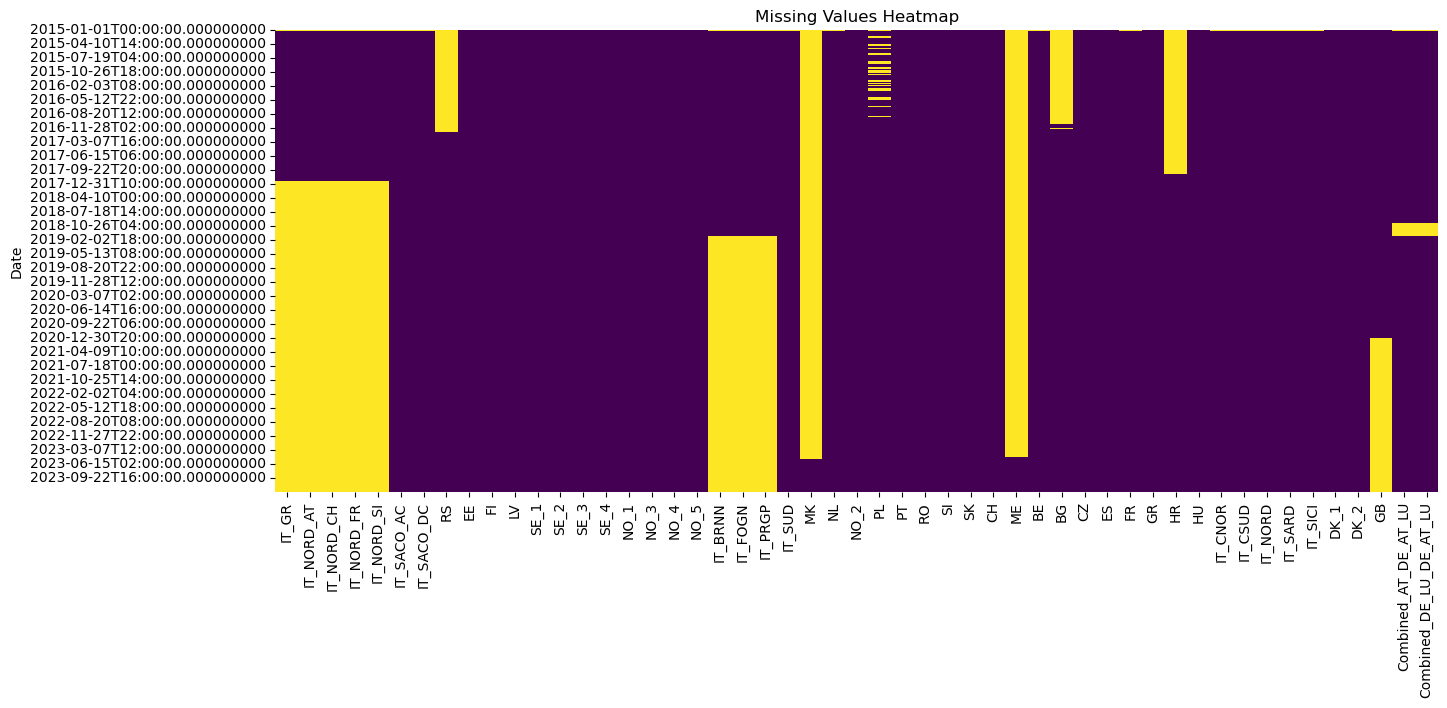

In [13]:
# Heatmap of missing values
plt.figure(figsize=(15, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

C:\Users\luisf\AppData\Local\Temp\ipykernel_8184\595503753.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  missing_by_year = df['IT_GR'].isnull().resample('Y').sum()


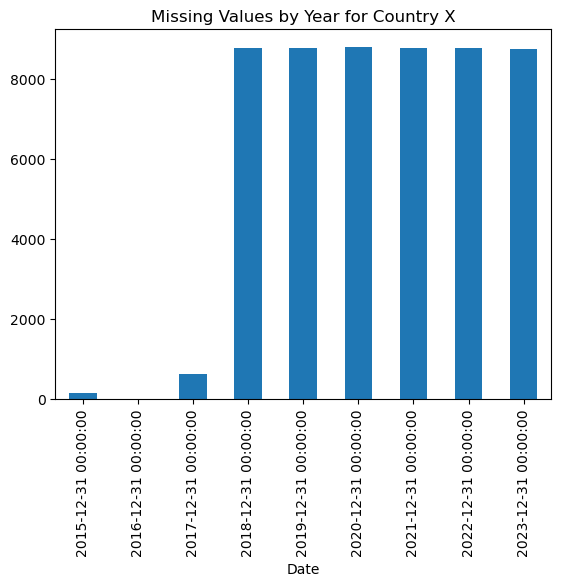

In [14]:
# Example: Count missing values by year for a specific country
missing_by_year = df['IT_GR'].isnull().resample('Y').sum()
missing_by_year.plot(kind='bar')
plt.title('Missing Values by Year for Country X')
plt.show()

C:\Users\luisf\AppData\Local\Temp\ipykernel_8184\856847962.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean = df.resample('M').mean()


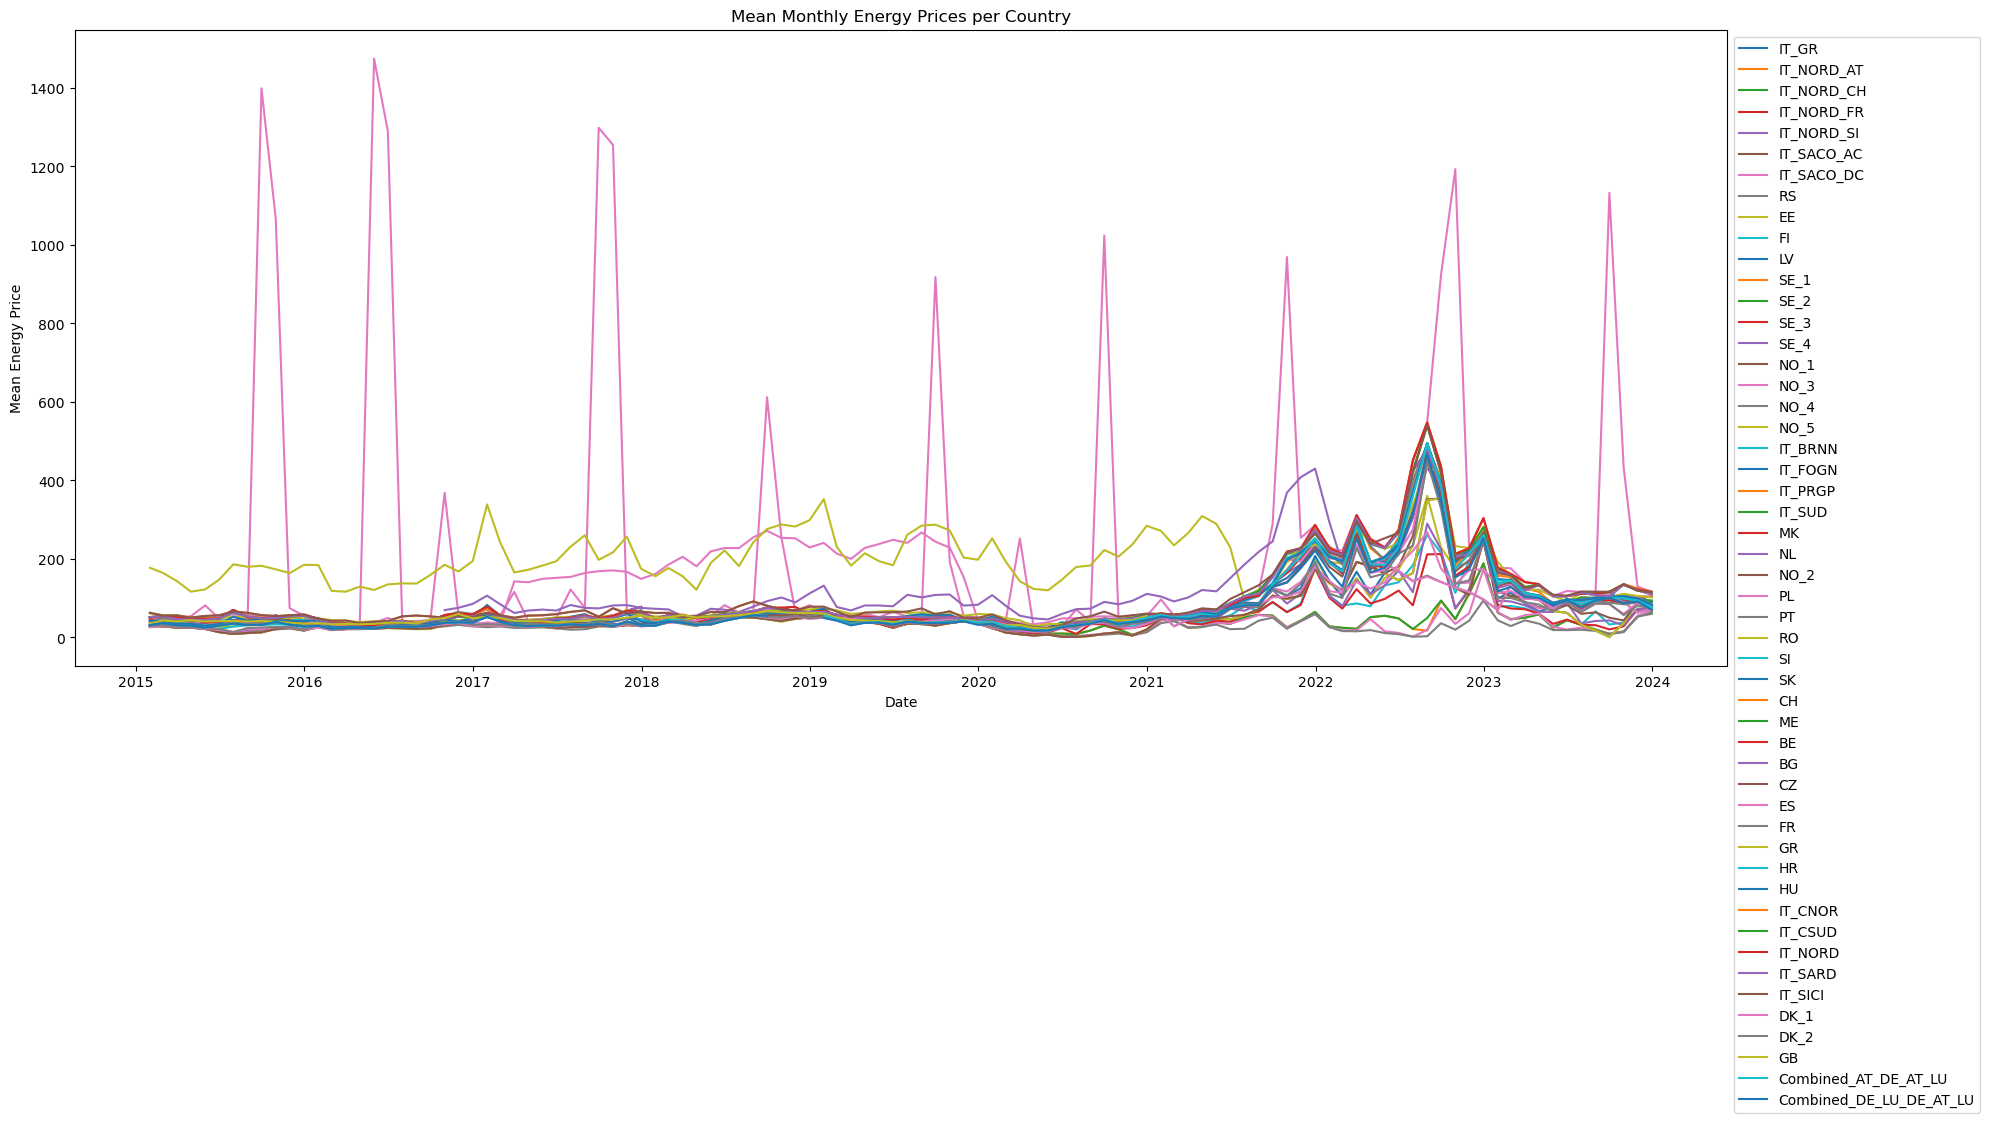

In [15]:
# Resample the data by month and calculate the mean for each country
monthly_mean = df.resample('M').mean()

# Plotting mean energy prices per month/year per country
plt.figure(figsize=(20, 10))  # You can adjust the size to fit your needs

for country in monthly_mean.columns:
    plt.plot(monthly_mean.index, monthly_mean[country], label=country)

plt.xlabel('Date')
plt.ylabel('Mean Energy Price')
plt.title('Mean Monthly Energy Prices per Country')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend out of the plot
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

# replicate by hour

In [16]:
result_price_dataframe['Date'] = pd.to_datetime(result_price_dataframe['Date'])
result_price_dataframe['Hourly_Period'] = result_price_dataframe['Date'].dt.to_period('H')
result_price_dataframe['Week_Period'] = result_price_dataframe['Date'].dt.to_period('W')
result_price_dataframe['Day_of_Week'] = result_price_dataframe['Date'].dt.dayofweek
result_price_dataframe['Month_Period'] = result_price_dataframe['Date'].dt.to_period('W')
result_price_dataframe

C:\Users\luisf\AppData\Local\Temp\ipykernel_8184\3441573777.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  result_price_dataframe['Hourly_Period'] = result_price_dataframe['Date'].dt.to_period('H')


,Date,Country,price,Hourly_Period,Week_Period,Day_of_Week,Month_Period
0,2015-01-01,EE,27.38,2015-01-01 00:00,2014-12-29/2015-01-04,3,2014-12-29/2015-01-04
1,2015-01-01,FI,27.38,2015-01-01 00:00,2014-12-29/2015-01-04,3,2014-12-29/2015-01-04
2,2015-01-01,LV,30.03,2015-01-01 00:00,2014-12-29/2015-01-04,3,2014-12-29/2015-01-04
3,2015-01-01,SE_1,27.38,2015-01-01 00:00,2014-12-29/2015-01-04,3,2014-12-29/2015-01-04
4,2015-01-01,SE_2,27.38,2015-01-01 00:00,2014-12-29/2015-01-04,3,2014-12-29/2015-01-04
...,...,...,...,...,...,...,...
3354225,2023-12-31,IT_SICI,109.12,2023-12-31 00:00,2023-12-25/2023-12-31,6,2023-12-25/2023-12-31
3354226,2023-12-31,AT,34.32,2023-12-31 00:00,2023-12-25/2023-12-31,6,2023-12-25/2023-12-31
3354227,2023-12-31,DE_LU,36.54,2023-12-31 00:00,2023-12-25/2023-12-31,6,2023-12-25/2023-12-31
3354228,2023-12-31,DK_1,44.87,2023-12-31 00:00,2023-12-25/2023-12-31,6,2023-12-25/2023-12-31


In [17]:
#error about  Converting from period[W-SUN] to int32 is not supported. Do obj.astype('int64').astype(dtype) instead
#result_price_dataframe_sample = result_price_dataframe.sample(n=1000, random_state=42)
#result_price_dataframe_sample['Week_Period'] = result_price_dataframe_sample['Week_Period'].astype(int)
#result_price_dataframe_sample['Month_Period'] = result_price_dataframe_sample['Month_Period'].astype(int)
#result_price_dataframe_sample['Hourly_Period'] = result_price_dataframe_sample['Hourly_Period'].astype(int)
#result_price_dataframe_sample['Day_of_Week'] = result_price_dataframe_sample['Day_of_Week'].astype(int)
#result_price_dataframe_sample

TypeError: Converting from period[W-SUN] to int32 is not supported. Do obj.astype('int64').astype(dtype) instead

In [18]:
result_price_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3354230 entries, 0 to 3354229
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Date           datetime64[ns]
 1   Country        object        
 2   price          float64       
 3   Hourly_Period  period[h]     
 4   Week_Period    period[W-SUN] 
 5   Day_of_Week    int32         
 6   Month_Period   period[W-SUN] 
dtypes: datetime64[ns](1), float64(1), int32(1), object(1), period[W-SUN](2), period[h](1)
memory usage: 166.3+ MB


In [19]:
X = result_price_dataframe_sample.drop(['price'], axis=1)
y = result_price_dataframe_sample['price']

In [ ]:
from sklearn.model_selection import train_test_split

# Filter the data based on years
train = result_price_dataframe_sample[result_price_dataframe['Date'].dt.year < 2020]
test = result_price_dataframe_sample[result_price_dataframe['Date'].dt.year >= 2020]

# Define features and target for training and testing sets
X_train = train.drop(['price', 'Date', 'Country'], axis=1)
y_train = train['price']
X_test = test.drop(['price', 'Date', 'Country'], axis=1)
y_test = test['price']

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (580, 4)
X_test shape: (420, 4)
y_train shape: (580,)
y_test shape: (420,)


/var/folders/8w/tn0n7t0s3xj25yhn7fm6r3gh0000gn/T/ipykernel_33555/3259640122.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = result_price_dataframe_sample[result_price_dataframe['Date'].dt.year < 2020]
/var/folders/8w/tn0n7t0s3xj25yhn7fm6r3gh0000gn/T/ipykernel_33555/3259640122.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test = result_price_dataframe_sample[result_price_dataframe['Date'].dt.year >= 2020]


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the RandomForestRegressor without specifying random_state
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)

RandomForestRegressor()

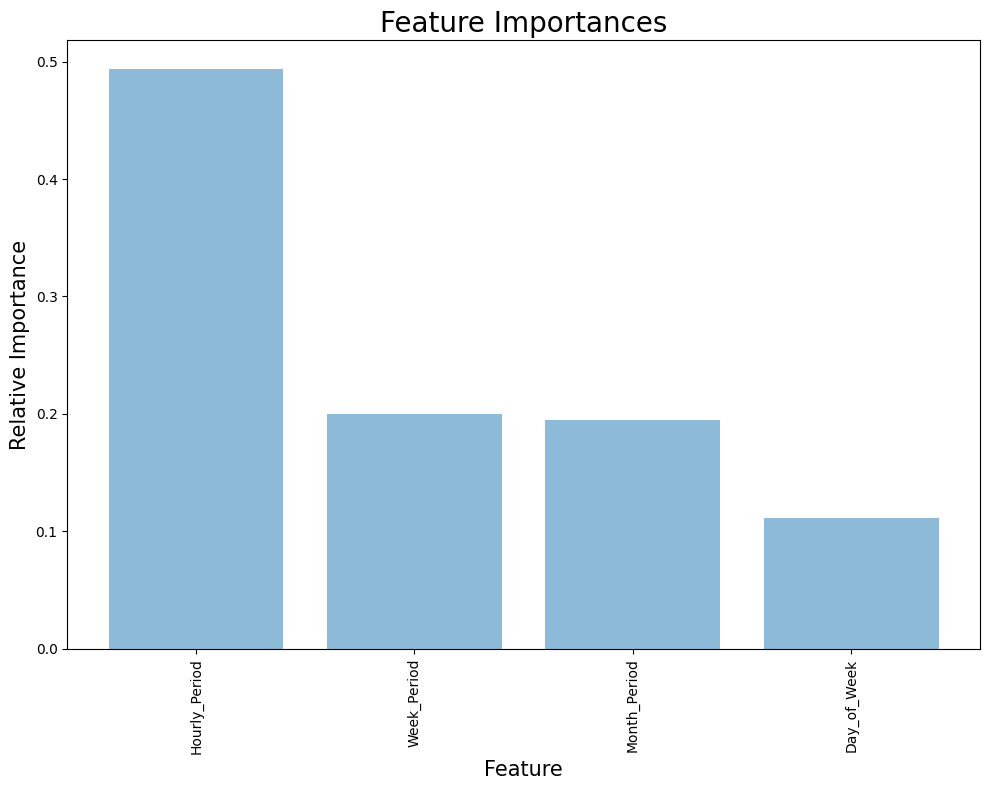

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate feature importances
feature_importances = rf.feature_importances_

# Adjusting feature_names to match your processed DataFrame
# Ensure this line comes after all preprocessing steps, including get_dummies and drop
feature_names = result_price_dataframe.drop(['price', 'Date', 'Country'], axis=1)

# Sort the feature importances in descending order and get their indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Create the plot
plt.figure(figsize=(10, 8))
plt.title('Feature Importances', fontsize=20)
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center', alpha=0.5)
plt.xticks(range(len(feature_importances)), feature_names.columns[sorted_indices], rotation=90)
plt.ylabel('Relative Importance', fontsize=15)
plt.xlabel('Feature', fontsize=15)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

In [ ]:
print(list(df.columns))

['IT_GR', 'IT_NORD_AT', 'IT_NORD_CH', 'IT_NORD_FR', 'IT_NORD_SI', 'IT_SACO_AC', 'IT_SACO_DC', 'RS', 'EE', 'FI', 'LV', 'SE_1', 'SE_2', 'SE_3', 'SE_4', 'NO_1', 'NO_3', 'NO_4', 'NO_5', 'IT_BRNN', 'IT_FOGN', 'IT_PRGP', 'IT_SUD', 'MK', 'NL', 'NO_2', 'PL', 'PT', 'RO', 'SI', 'SK', 'CH', 'ME', 'BE', 'BG', 'CZ', 'ES', 'FR', 'GR', 'HR', 'HU', 'IT_CNOR', 'IT_CSUD', 'IT_NORD', 'IT_SARD', 'IT_SICI', 'AT', 'DE_AT_LU', 'DE_LU', 'DK_1', 'DK_2', 'GB', 'Year', 'Combined_AT_DE_AT_LU', 'Combined_DE_LU_DE_AT_LU']


In [22]:
result_price_dataframe = df.copy()  
result_price_dataframe.dropna(axis=1, how='all', inplace=True)

# Stack the DataFrame to move the column names to index levels
result_price_dataframe = result_price_dataframe.stack().reset_index()

# Rename columns for clarity
result_price_dataframe.rename(columns={0: 'price', 'level_0': 'Date', 'level_1': 'Country'}, inplace=True)

# Set the index to Date and Country
result_price_dataframe

,Date,Country,price
0,2015-01-01,EE,27.38
1,2015-01-01,FI,27.38
2,2015-01-01,LV,30.03
3,2015-01-01,SE_1,27.38
4,2015-01-01,SE_2,27.38
...,...,...,...
3382566,2023-12-31,IT_SICI,109.12
3382567,2023-12-31,DK_1,44.87
3382568,2023-12-31,DK_2,44.87
3382569,2023-12-31,Combined_AT_DE_AT_LU,34.32


In [23]:
# Transform the "Country" variable into dummy variables
country_dummies = pd.get_dummies(result_price_dataframe['Country'], prefix='Country')

# Concatenate the dummy variables with the original DataFrame
result_price_dataframe = pd.concat([result_price_dataframe, country_dummies], axis=1)

# Drop the original "Country" column if needed
result_price_dataframe = result_price_dataframe.drop('Country', axis=1)


In [24]:
result_price_dataframe

,Date,price,Country_BE,Country_BG,Country_CH,Country_CZ,Country_Combined_AT_DE_AT_LU,Country_Combined_DE_LU_DE_AT_LU,Country_DK_1,Country_DK_2,...,Country_PL,Country_PT,Country_RO,Country_RS,Country_SE_1,Country_SE_2,Country_SE_3,Country_SE_4,Country_SI,Country_SK
0,2015-01-01,27.38,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2015-01-01,27.38,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2015-01-01,30.03,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2015-01-01,27.38,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,2015-01-01,27.38,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3382566,2023-12-31,109.12,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3382567,2023-12-31,44.87,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3382568,2023-12-31,44.87,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3382569,2023-12-31,34.32,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
print(list(result_price_dataframe.columns))

['Date', 'price', 'Country_BE', 'Country_BG', 'Country_CH', 'Country_CZ', 'Country_Combined_AT_DE_AT_LU', 'Country_Combined_DE_LU_DE_AT_LU', 'Country_DK_1', 'Country_DK_2', 'Country_EE', 'Country_ES', 'Country_FI', 'Country_FR', 'Country_GB', 'Country_GR', 'Country_HR', 'Country_HU', 'Country_IT_BRNN', 'Country_IT_CNOR', 'Country_IT_CSUD', 'Country_IT_FOGN', 'Country_IT_GR', 'Country_IT_NORD', 'Country_IT_NORD_AT', 'Country_IT_NORD_CH', 'Country_IT_NORD_FR', 'Country_IT_NORD_SI', 'Country_IT_PRGP', 'Country_IT_SACO_AC', 'Country_IT_SACO_DC', 'Country_IT_SARD', 'Country_IT_SICI', 'Country_IT_SUD', 'Country_LV', 'Country_ME', 'Country_MK', 'Country_NL', 'Country_NO_1', 'Country_NO_2', 'Country_NO_3', 'Country_NO_4', 'Country_NO_5', 'Country_PL', 'Country_PT', 'Country_RO', 'Country_RS', 'Country_SE_1', 'Country_SE_2', 'Country_SE_3', 'Country_SE_4', 'Country_SI', 'Country_SK', 'Hourly_Period', 'Week_Period', 'Day_of_Week', 'Month_Period']


In [25]:
result_price_dataframe['Date'] = pd.to_datetime(result_price_dataframe['Date'])
result_price_dataframe['Hourly_Period'] = result_price_dataframe['Date'].dt.to_period('H')
result_price_dataframe['Week_Period'] = result_price_dataframe['Date'].dt.to_period('W')
result_price_dataframe['Day_of_Week'] = result_price_dataframe['Date'].dt.dayofweek
result_price_dataframe['Month_Period'] = result_price_dataframe['Date'].dt.to_period('W')
result_price_dataframe

C:\Users\luisf\AppData\Local\Temp\ipykernel_8184\3441573777.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  result_price_dataframe['Hourly_Period'] = result_price_dataframe['Date'].dt.to_period('H')


,Date,price,Country_BE,Country_BG,Country_CH,Country_CZ,Country_Combined_AT_DE_AT_LU,Country_Combined_DE_LU_DE_AT_LU,Country_DK_1,Country_DK_2,...,Country_SE_1,Country_SE_2,Country_SE_3,Country_SE_4,Country_SI,Country_SK,Hourly_Period,Week_Period,Day_of_Week,Month_Period
0,2015-01-01,27.38,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2015-01-01 00:00,2014-12-29/2015-01-04,3,2014-12-29/2015-01-04
1,2015-01-01,27.38,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2015-01-01 00:00,2014-12-29/2015-01-04,3,2014-12-29/2015-01-04
2,2015-01-01,30.03,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2015-01-01 00:00,2014-12-29/2015-01-04,3,2014-12-29/2015-01-04
3,2015-01-01,27.38,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,2015-01-01 00:00,2014-12-29/2015-01-04,3,2014-12-29/2015-01-04
4,2015-01-01,27.38,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,2015-01-01 00:00,2014-12-29/2015-01-04,3,2014-12-29/2015-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3382566,2023-12-31,109.12,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2023-12-31 00:00,2023-12-25/2023-12-31,6,2023-12-25/2023-12-31
3382567,2023-12-31,44.87,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,2023-12-31 00:00,2023-12-25/2023-12-31,6,2023-12-25/2023-12-31
3382568,2023-12-31,44.87,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,2023-12-31 00:00,2023-12-25/2023-12-31,6,2023-12-25/2023-12-31
3382569,2023-12-31,34.32,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,2023-12-31 00:00,2023-12-25/2023-12-31,6,2023-12-25/2023-12-31


Building a dataframe with new features  

In [2]:
import pandas as pd
from entsoe import EntsoeRawClient
from entsoe import EntsoePandasClient
import numpy as np
import matplotlib.pyplot as plt
import itertools
import collections
from multiprocessing.pool import ThreadPool
from itertools import product

In [10]:
client = EntsoePandasClient(api_key='000ce54c-70cd-4007-ace0-6c156aa696d1')

In [11]:
time=pd.date_range(start='2015-01-01 00:00:00+01:00', end='2023-12-31 00:00:00+01:00', freq='h')

In [12]:
BiddingZone = ['AT','DE_AT_LU', 'DE_LU','DK_1', 'DK_2', 'GB', 'BA']

In [33]:
windSolarData = client.query_wind_and_solar_forecast(country_code='DE_AT_LU', start = pd.Timestamp('20150101', tz='Europe/Brussels'), end = pd.Timestamp('20231231', tz='Europe/Brussels'), psr_type=None)

In [34]:
windSolarData

,Solar,Wind Offshore,Wind Onshore
2015-01-01 00:00:00+01:00,0.0,258.0,7518.0
2015-01-01 00:15:00+01:00,0.0,258.0,7603.0
2015-01-01 00:30:00+01:00,0.0,259.0,7695.0
2015-01-01 00:45:00+01:00,0.0,259.0,7779.0
2015-01-01 01:00:00+01:00,0.0,259.0,8108.0
...,...,...,...
2018-09-30 22:45:00+02:00,0.0,1475.0,4696.0
2018-09-30 23:00:00+02:00,0.0,1459.0,4737.0
2018-09-30 23:15:00+02:00,0.0,1455.0,4725.0
2018-09-30 23:30:00+02:00,0.0,1452.0,4718.0


In [35]:
windSolarData.to_csv("windSolarData_DE_AT_LU.csv")

In [3]:
#create file for de_at_u

df_AT = pd.read_csv("windSolarData_AT.csv")
df_BE = pd.read_csv("windSolarData_BE.csv")
df_BG = pd.read_csv("windSolarData_BG.csv")
df_CH = pd.read_csv("windSolarData_CH.csv")
df_CZ = pd.read_csv("windSolarData_CZ.csv")
df_DK1 = pd.read_csv("windSolarData_DK_1.csv")

In [3]:
print(df_AT)

                       Unnamed: 0  Solar  Wind Onshore
0       2015-01-01 00:00:00+01:00    0.0         118.0
1       2015-01-01 00:15:00+01:00    0.0         118.0
2       2015-01-01 00:30:00+01:00    0.0         117.0
3       2015-01-01 00:45:00+01:00    0.0         116.0
4       2015-01-01 01:00:00+01:00    0.0         146.0
...                           ...    ...           ...
315443  2023-12-30 22:45:00+01:00    0.0         300.0
315444  2023-12-30 23:00:00+01:00    0.0         284.0
315445  2023-12-30 23:15:00+01:00    0.0         284.0
315446  2023-12-30 23:30:00+01:00    0.0         284.0
315447  2023-12-30 23:45:00+01:00    0.0         280.0

[315448 rows x 3 columns]


In [54]:
df = pd.read_csv("aggregate_AT_BE_BG_CH_CZ_DK_1.CSV")

C:\Users\luisf\AppData\Local\Temp\ipykernel_3156\117437388.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("aggregate_AT_BE_BG_CH_CZ_DK_1.CSV")


In [59]:
DE_AT_LU = pd.read_csv("windSolarData_DE_AT_LU.csv")
AT = pd.read_csv("windSolarData_AT.csv")

In [60]:
df.index = pd.to_datetime(df.index)

In [61]:
df['Year'] = df.index.year

In [62]:
df['Combined_AT_DE_AT_LU'] = df.apply(lambda row: row['DE_AT_LU'] if row['Year'] <= 2018 else row['AT'], axis=1)

KeyError: 'DE_AT_LU'

In [53]:
#df_AT.index = pd.to_datetime(df_AT.index)
#df_AT['Year'] = df.index.year
#df_AT['Combined_AT_DE_AT_LU'] = df_AT.apply(lambda row: row['DE_AT_LU'] if row['Year'] <= 2018 else row['AT'], axis=1)
#df_AT['Combined_DE_LU_DE_AT_LU'] = df_AT.apply(lambda row: row['DE_AT_LU'] if row['Year'] <= 2018 else row['DE_LU'], axis=1)

In [6]:
#Until 2018, the energy price market had a joint trading zone between Austria, Germany and Luxembourg. After 2018, a separate market appeared in Austria. So we need to merge the columns for them.
#df = pd.read_csv('entsoe2015-2023.csv', index_col=0)
#df = df.rename_axis('Date')
print(df)

#first sequence to create this dataframes 
#df.index = pd.to_datetime(df.index)
#df['Year'] = df.index.year
#df['Combined_AT_DE_AT_LU'] = df.apply(lambda row: row['DE_AT_LU'] if row['Year'] <= 2018 else row['AT'], axis=1)
#df['Combined_DE_LU_DE_AT_LU'] = df.apply(lambda row: row['DE_AT_LU'] if row['Year'] <= 2018 else row['DE_LU'], axis=1)
#chunk 2 
#exclude_columns = ['DE_AT_LU', 'AT', 'DE_LU', 'Year']
#df.drop(columns=exclude_columns, inplace=True)
#print(df)

                     IT_GR  IT_NORD_AT  IT_NORD_CH  IT_NORD_FR  IT_NORD_SI  \
Date                                                                         
2015-01-01 00:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 01:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 02:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 03:00:00    NaN         NaN         NaN         NaN         NaN   
2015-01-01 04:00:00    NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
2023-12-30 20:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-30 21:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-30 22:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-30 23:00:00    NaN         NaN         NaN         NaN         NaN   
2023-12-31 00:00:00    NaN         NaN         NaN         NaN  

In [28]:
df_AT.describe()

,Solar,Wind Onshore
count,315448.000000,315448.000000
mean,165.768431,782.680867
std,262.788362,690.393550
min,0.000000,0.000000
25%,0.000000,229.000000
50%,14.000000,560.000000
75%,252.000000,1156.000000
max,1988.000000,3436.000000


In [10]:
def get_country_index(filename):
    # This assumes the relevant part starts right after 'storage_' and goes until '.csv'
    start_index = filename.find('windSolarData_') + len('windSolarData_')
    end_index = filename.rfind('.csv')
    return filename[start_index:end_index]

In [47]:
def get_country_index(filename):
    # Assumes the country code is right after the last underscore and before ".csv"
    return filename.split('_')[-1].split('.')[0]

In [11]:
df_AT['country_index']  = get_country_index("windSolarData_AT.csv")
df_BE['country_index']  = get_country_index("windSolarData_BE.csv")
df_BG['country_index']  = get_country_index("windSolarData_BG.csv")
df_CH['country_index']  = get_country_index("windSolarData_CH.csv")
df_CZ['country_index']  = get_country_index("windSolarData_CZ.csv")
df_DK1['country_index']  = get_country_index("windSolarData_DK_1.csv")

In [12]:
df_AT

,Unnamed: 0,Solar,Wind Onshore,country_index
0,2015-01-01 00:00:00+01:00,0.0,118.0,AT
1,2015-01-01 00:15:00+01:00,0.0,118.0,AT
2,2015-01-01 00:30:00+01:00,0.0,117.0,AT
3,2015-01-01 00:45:00+01:00,0.0,116.0,AT
4,2015-01-01 01:00:00+01:00,0.0,146.0,AT
...,...,...,...,...
315443,2023-12-30 22:45:00+01:00,0.0,300.0,AT
315444,2023-12-30 23:00:00+01:00,0.0,284.0,AT
315445,2023-12-30 23:15:00+01:00,0.0,284.0,AT
315446,2023-12-30 23:30:00+01:00,0.0,284.0,AT


In [13]:
merged_df =pd.concat([df_AT,df_BE,df_BG,df_CH,df_CZ,df_DK1])
print(merged_df)

                      Unnamed: 0  Solar  Wind Onshore country_index  \
0      2015-01-01 00:00:00+01:00    0.0         118.0            AT   
1      2015-01-01 00:15:00+01:00    0.0         118.0            AT   
2      2015-01-01 00:30:00+01:00    0.0         117.0            AT   
3      2015-01-01 00:45:00+01:00    0.0         116.0            AT   
4      2015-01-01 01:00:00+01:00    0.0         146.0            AT   
...                          ...    ...           ...           ...   
78611  2023-12-30 19:00:00+01:00    0.0         665.0          DK_1   
78612  2023-12-30 20:00:00+01:00    0.0         466.0          DK_1   
78613  2023-12-30 21:00:00+01:00    0.0         323.0          DK_1   
78614  2023-12-30 22:00:00+01:00    0.0         227.0          DK_1   
78615  2023-12-30 23:00:00+01:00    0.0         184.0          DK_1   

       Wind Offshore  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...      

In [14]:
 merged_df.to_csv('merged_AT_BE_BG_CH_CZ_DK_1.CSV')

In [3]:
df2 = pd.read_csv("merged_luisfer.CSV")

In [9]:
df3 = pd.read_csv("merged_camilo.csv")

In [10]:
df3

,Unnamed: 0,Date,Solar,Wind Offshore,country_index,Wind Onshore
0,0,2015-01-07 00:00:00+01:00,0.0,316.0,DK_2,267.0
1,1,2015-01-07 01:00:00+01:00,0.0,302.0,DK_2,235.0
2,2,2015-01-07 02:00:00+01:00,0.0,269.0,DK_2,204.0
3,3,2015-01-07 03:00:00+01:00,0.0,234.0,DK_2,173.0
4,4,2015-01-07 04:00:00+01:00,0.0,182.0,DK_2,142.0
...,...,...,...,...,...,...
1048570,58440,2021-09-01 07:00:00+02:00,65.0,NaN,IT_CNOR,3.0
1048571,58441,2021-09-01 08:00:00+02:00,271.0,NaN,IT_CNOR,4.0
1048572,58442,2021-09-01 09:00:00+02:00,509.0,NaN,IT_CNOR,4.0
1048573,58443,2021-09-01 10:00:00+02:00,684.0,NaN,IT_CNOR,6.0


In [5]:
df2

,Unnamed: 0,Date,Solar,Wind Onshore,country_index,Wind Offshore
0,0,2015-01-01 00:00:00+01:00,0.0,118.0,AT,NaN
1,1,2015-01-01 00:15:00+01:00,0.0,118.0,AT,NaN
2,2,2015-01-01 00:30:00+01:00,0.0,117.0,AT,NaN
3,3,2015-01-01 00:45:00+01:00,0.0,116.0,AT,NaN
4,4,2015-01-01 01:00:00+01:00,0.0,146.0,AT,NaN
...,...,...,...,...,...,...
705207,78611,2023-12-30 19:00:00+01:00,0.0,665.0,DK_1,570.0
705208,78612,2023-12-30 20:00:00+01:00,0.0,466.0,DK_1,452.0
705209,78613,2023-12-30 21:00:00+01:00,0.0,323.0,DK_1,352.0
705210,78614,2023-12-30 22:00:00+01:00,0.0,227.0,DK_1,315.0
